#Tarea 4: Generative AI
Pablo Gabriel Galeana Benítez - A01735281




---



## Introducción

En el presente trabajo se abordo el problema de generación de texto utilizando redes neuronales recurrentes, en especifico las denominadas Long-Short Term Memory con un enfoque de caractéres, que se codificaron utilizando el algoritmo Bag of Words. Se entrenaron dos diferentes modelos con el fin de medir o comparar el efecto del tuneo del tamaño de la secuencia de palabras durante el entrenamiento.

El codigo original corresponde a Sunny Solanski y esta es meramente una adaptación. Se puede encontrar el original en:

[Keras: Text Generation using LSTM Networks (Character-based RNN)](https://coderzcolumn.com/tutorials/artificial-intelligence/keras-text-generation-using-lstm-networks)





---



## Preparación del dataset


  Previo a entrenar los modelos, se requiere realizar algunos preparativos con el fin de conocer a profundidad como entrarán los datos y porque funcionan.

Primeramente, cargamos las librerías necesarias para poder funcionar.

In [18]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import shutil
import pandas as pd
import torchtext
import gc
import numpy as np
import random
import pickle


Comunmente el tamaño de los datasets es bastante grande con el fin de que este sea lo suficientemente variado y por lo tanto el modelo pueda generalizar. Sin embargo, esto hace que el entrenamiento sea bastante tardado y fuerce mucho la capacidad computacional. Una manera de acelerar este proceso es utilizar unidades de procesamiento de graficos (GPU), las cuales trabajan muy bien con tensores.

Para poder utilizar estas GPU se desarrolló el codigo en Google Colab, sin embargo, solo se puede utilizar por un corto periodo de tiempo al día, por lo cual se opto por guardar los modelos y sus historiales de entrenamiento una vez ha terminado de correr el entrenamiento.

Para ello, es necesario cargar el drive en el notebook para acceder a las carpetas.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Una vez cargado el drive, nos movemos a la carpeta requerida.

In [3]:
%cd /content/drive/Shareddrives/Deep Learning/GenerativeAI

/content/drive/Shareddrives/Deep Learning/GenerativeAI


El dataset se cargo desde la librería torchtext, pero por cuestiones de compatabilidad se requiere instalar la librería portalocker, la cual administra recursos y procesos computacionales para evitar que estos interfieran unos con otros.

In [1]:
!pip install 'portalocker'

Una vez esta todo listo, se puede proceder a cargar el dataset. Este tiene por nombre WikiText2 y es una versión superior de WikiText103 que comprende una determinada cantidad de articulos publicados en Wikipedia. Estos articulos fueron clasificados como verosimiles y se mantuvieron tal cual fueron publicados, es decir, contienen todos y cada uno de los numeros y caractéres, con y sin signos de puntuación existentes, así como algunos Kanjis y letras de idiomas diferentes al inglés.

La documentación oficial del dataset se puede hallar en el siguiente link:

[The WikiText Long Term Dependency Language Modeling Dataset](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/)

Por si solo, el dataset en torchtext ya se encuentra dividido en entrenamiento, validación y prueba, por lo que no será nevcesario dividirlo.

In [4]:
train_dataset, valid_dataset, test_dataset = torchtext.datasets.WikiText2()

Debido a que se carga como un objeto de Torchtext, es necesario iterar sobre el objeto para definir una nueva variable como un conjunto de los caractéres contenidos dentro de los subsets.

In [5]:
X_train_text = [text for text in train_dataset] #Iteramos sobre los subsets
X_val_text = [text for text in valid_dataset]
X_test_text  = [text for text in test_dataset]


print('Longitud de entrenamiento:', len(X_train_text))
print('Longitud de validacion:', len(X_val_text))
print('Longitud de prueba:', len(X_test_text))

Longitud de entrenamiento: 36718
Longitud de validacion: 3760
Longitud de prueba: 4358


Notamos que estan aproximadamente divididos 80-10-10

Una vez tenemos los subsets preparados, es necesario tokenizar los caracteres. En el proceso de tokenización, convertimos cada caracter a un token unico (por lo que se le puede asignar un indice), formando un vocabulario basado en caracteres en lugar de palabras (como comunmente puede suceder en ciertos casos).

Primero importamos la función de tokenización

In [6]:
tokenizer = Tokenizer(char_level=True)


Formamos nuestro vocabulario a partir del subset de entrenamiento, naturalmente, ya quese debería de contener todos los caracteres necesarios para la validación y prueba si consideramos su tamaño.

In [7]:
tokenizer.fit_on_texts(X_train_text)

Ahora podemos mostrar nuestro vocabulario y los indices que se le asignó a cada uno de los caracteres.

In [8]:
#Podemos asignar
word_index = tokenizer.word_index

# Convertir el diccionario a una lista de tuplas (palabra, índice)
word_index_list = [(word, index) for word, index in word_index.items()]

# Crear un DataFrame a partir de la lista de tuplas
df = pd.DataFrame(word_index_list, columns=['Word', 'Index'])

# Mostrar el DataFrame
df

,Word,Index
0,,1
1,e,2
2,t,3
3,a,4
4,n,5
...,...,...
238,ს,239
239,ძ,240
240,წ,241
241,გ,242


Ahora que tenemos nuestro vocabulario, podemos transformar nuestro subconjutno de entrenamiento para que el modelo sea capaz de entenderlo.

Basicamente, separamos en la entrada y la salida del modelo, para ello, definimos un tamaño de secuencia de entrada, que en este caso es de 100. Posteriormente, iteramos a través de los primeros 6000 caracteres para crear un tensor de secuencias que corresponden a todas las que se encuentran en esos primeros ejemplos (1-100, 2-101, ... 5901-600). Simultaneamennte, se define el caracter inmediato siguiente a la secuencia como la salida del modelo.

Todos los caracteres de las entradas y salidas se convierten a minusculas y se tokenizan para que puedan funcionar como entrada.

In [9]:
seq_length = 100 # Tamaño de la secuencia
X_train, Y_train = [], []

for text in X_train_text[:6000]: #Numero de ejemplos a usar
    for i in range(0, len(text)-seq_length):
        inp_seq = text[i:i+seq_length].lower()
        out_seq = text[i+seq_length].lower()
        X_train.append(inp_seq)
        Y_train.append(tokenizer.word_index[out_seq]) ## Retrieve index for characters from vocabulary

X_train = tokenizer.texts_to_sequences(X_train) ## Retrieve index for characters from vocabulary

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

((1377719, 100, 1), (1377719,))

Hacemos lo mismo para el de prueba pero soolo los primeros 200:

In [10]:
seq_length = 100 # Tamaño de la secuencia
X_test, Y_test = [], []

for text in X_test_text[:200]: #Numero de ejemplos a usar
    for i in range(0, len(text)-seq_length):
        inp_seq = text[i:i+seq_length].lower()
        out_seq = text[i+seq_length].lower()
        X_test.append(inp_seq)
        Y_test.append(tokenizer.word_index[out_seq]) ## Retrieve index for characters from vocabulary

X_test = tokenizer.texts_to_sequences(X_test) ## Retrieve index for characters from vocabulary

X_test, Y_test = np.array(X_test, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_test)

X_test.shape, Y_test.shape

((42351, 100, 1), (42351,))

## Primero modelo: Entrenamiento 1

Ahora que tenemos nuestras entradas y salidas del modelo durante el entrenamiento, podemos definir la arquitectura del modelo, el cual es una RNN con 3 capas:

- Primera capa: Long-Short Term Memory con entrada de 100,1 y salida de 256
- Segunda capa: Long-Short Term Memory con entrada y salida igual a la salida de la anterior.
- Tercera y ultima capa: Densa correspondiente a la salida y de tamaño igual al tamaño del vocabulario más uno.



In [ ]:
lstm_out = 256

model = Sequential([
                    LSTM(lstm_out, input_shape=(seq_length, 1), return_sequences=True),
                    LSTM(lstm_out),
                    Dense(len(tokenizer.word_index)+1, activation="softmax")
                ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 244)               62708     
                                                                 
Total params: 852212 (3.25 MB)
Trainable params: 852212 (3.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Una vez definida la arquitectura definimos el optimizador, el learning rate y la función de perdida:

- Optimizador: Adam
- Learning rate: 0.001
- Funcion de perdida: Entropía cruzada categorica

Notamos que se trata de un learning rate un poco alto, debido a que se pretende que el logré encontrar un buen minimo dentro de las primeras epocas.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy")

Ahora entrenamos al modelo por 50 epocas y un batch size de 1024.

In [ ]:
if False:
  history = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=1)

Una vez entrenado, guardamos el modelo, así como el historial de entrenamiento para analizar el desarrollo.

In [ ]:
if False:
  model.save('model.h5')

  with open('history.pkl', 'wb') as file:
      pickle.dump(history.history, file)

Mostramos la perdida durante el entrenamiento

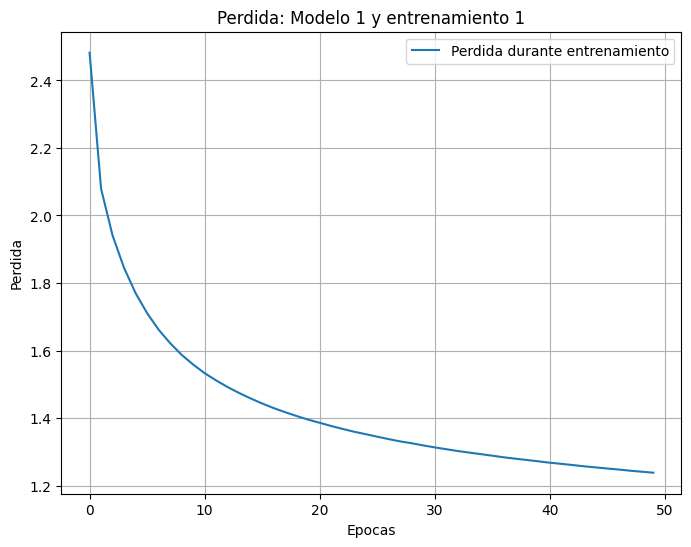

In [21]:
# Cargar el archivo history.pkl
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener la pérdida del conjunto de entrenamiento
loss = history['loss']

# Graficar la pérdida del conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Perdida durante entrenamiento')
plt.title('Perdida: Modelo 1 y entrenamiento 1')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

Observamos un buen entrenamiento, con la perdida disminuyendo adecuadamente y tratando de converger en un punto minimo local.

Naturalmente, se esperaría que existiera tambien la precisión y los resultados del conjunto de validación, pero debido a problemas al cargar el modelo durante el entrenamiento (falta de recursos), esto no fue posible.

Ahora cargamos el modelo para poder realizar predicciones

In [13]:
model = load_model('model.h5')

Para realizar predicciones, definimos un tamaño de secuencia posterior al primer caracter a predecir para que generé una cantidad definida de texto (en este caso 100). Se establece un indice aleatorio y se predice a partir de ahí. A diferencia del codigo original, aqui se utiliza el conjunto de prueba para predecir y se agrega un parametro importante: Temperatura. Al ajustar la temperatura, se modifica la distribución de probabilidad sobre las predicciones del modelo antes de seleccionar el siguiente carácter en la secuencia generada.

En otras palabras, se podría considerar que se define que tanta exploración realiza el modelo antes de predicción, siendo secuencias más predecibles (y por lo tanto logicas) a más baja temperatura. Se utilizarón 4 diferentes temperaturas para observar el efecto en la generación de texto.

Para evaluar el desempeño del modelo, naturalmente, habría que quizá definir las diferencias caracter a caracter de los generados, sin embargo, se complica debido a la cantidad de texto y las clases, así como el aún poco y ligero (debido al learning rate) entrenamiento. Por ello, se evaluará en función de que tan vago es el texto producido en comparación del original.



In [16]:
random.seed(123)
idx = random.randint(0, len(X_test))
pattern = X_test[idx].flatten().tolist()
real_sequence = Y_test[idx:idx+100].flatten().tolist()

print("Initial Pattern : {}".format("".join([tokenizer.index_word[idx] for idx in pattern])))
print("Real Sequence : {}".format("".join([tokenizer.index_word[idx] for idx in real_sequence])))


temperatures = [0.2, 0.5, 1.0, 1.5]  # Lista de diferentes valores de temperatura

for temp in temperatures:
    print(f"\n--- Generated Text (Temperature: {temp}) ---")
    generated_text = []
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length, 1)
        preds = model.predict(X_batch, verbose=0)

        # Aplicar temperatura a las predicciones antes de muestrear el índice
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Muestreo de acuerdo a las probabilidades ajustadas por temperatura
        predicted_index = np.random.choice(len(preds[0]), p=preds[0])

        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]

    print("".join([tokenizer.index_word[idx] for idx in generated_text]))

Initial Pattern : f how to curse directed by <unk> <unk> . how to curse was performed at bush theatre in the london bo
Real Sequence : rough of <unk> and fulham . in a review of the production for the daily telegraph , theatre critic c

--- Generated Text (Temperature: 0.2) ---


<ipython-input-16-56e445f52def>:21: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temp


ok . after the state of the story of the second production of the command of the command of the firs

--- Generated Text (Temperature: 0.5) ---
t appearances . 
875 , and shortly after the provide state to produce of the female had been commiss

--- Generated Text (Temperature: 1.0) ---
ion , which began in peace . however well " we k earlier fouuow " these stuame , a perhon in things 

--- Generated Text (Temperature: 1.5) ---
bouls ' that <unk> was cullen j <unk> prankwahsed lungo , ep timb agpllar . 
961 . i complesyuog wob


Notamos que las primeras dos temperaturas contienen dentro de lo que cabe, secuencias de texto un tanto más logicas y que incluso, llegan a coincidir en cierto punto con la secuencia real. Por otro lado, notamos que las ultimas dos resultan un tanto más alucinantes e incluso irreales.

## Primero modelo: Entrenamiento 2

Los primeros resultados, no muestran algo muy conciso por lo que se entrenerá durante al menos otras 50 epocas, pero en este caso, con un learning rate de 0.0003 con el fin de no subajustar al modelo y dirigirlo hacia un mejor desempeño.

In [ ]:
if False:
  K.set_value(model.optimizer.learning_rate, 0.0003)

  history2 = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=1)

Epoch 1/50
1346/1346 [==============================] - 236s 170ms/step - loss: 1.2218
Epoch 2/50
1346/1346 [==============================] - 242s 180ms/step - loss: 1.2191
Epoch 3/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2175
Epoch 4/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2160
Epoch 5/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2148
Epoch 6/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2133
Epoch 7/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2121
Epoch 8/50
1346/1346 [==============================] - 245s 182ms/step - loss: 1.2106
Epoch 9/50
1346/1346 [==============================] - 247s 184ms/step - loss: 1.2093
Epoch 10/50
1346/1346 [==============================] - 248s 184ms/step - loss: 1.2083
Epoch 11/50
1346/1346 [==============================] - 248s 184ms/step - loss: 1.2070
Epoch 12/50
1346/1346 [==================

Similarmente, guardamos el modelo y su historial de entrenamiento

In [ ]:
if False:
  model.save('model_2".h5')

  with open('history2.pkl', 'wb') as file:
      pickle.dump(history2.history, file)

Mostramos el siguiente historial de perdida.

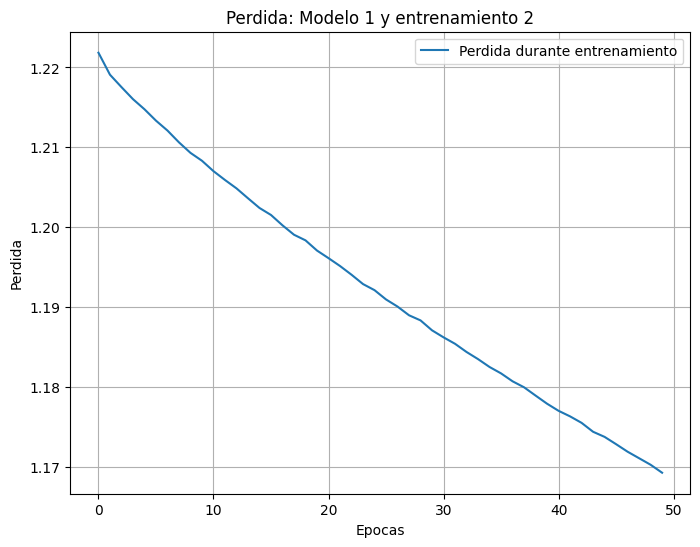

In [22]:
# Cargar el archivo history.pkl
with open('history2.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener la pérdida del conjunto de entrenamiento
loss = history['loss']

# Graficar la pérdida del conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Perdida durante entrenamiento')
plt.title('Perdida: Modelo 1 y entrenamiento 2')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

Notamos que continua bajando, pero esta vez claramente un poco más lento.


Cargamos el modelo para realizar predicciones.

In [23]:
model = load_model('model_2.h5')

In [25]:
random.seed(123)
idx = random.randint(0, len(X_test))
pattern = X_test[idx].flatten().tolist()
real_sequence = Y_test[idx:idx+100].flatten().tolist()

print("Initial Pattern : {}".format("".join([tokenizer.index_word[idx] for idx in pattern])))
print("Real Sequence : {}".format("".join([tokenizer.index_word[idx] for idx in real_sequence])))


temperatures = [0.2, 0.5, 1.0, 1.5]  # Lista de diferentes valores de temperatura

for temp in temperatures:
    print(f"\n--- Generated Text (Temperature: {temp}) ---")
    generated_text = []
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length, 1)
        preds = model.predict(X_batch, verbose=0)

        # Aplicar temperatura a las predicciones antes de muestrear el índice
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Muestreo de acuerdo a las probabilidades ajustadas por temperatura
        predicted_index = np.random.choice(len(preds[0]), p=preds[0])

        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]

    print("".join([tokenizer.index_word[idx] for idx in generated_text]))

Initial Pattern : f how to curse directed by <unk> <unk> . how to curse was performed at bush theatre in the london bo
Real Sequence : rough of <unk> and fulham . in a review of the production for the daily telegraph , theatre critic c

--- Generated Text (Temperature: 0.2) ---


<ipython-input-25-56e445f52def>:21: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temp


ard of the second community of the south of the production of the season . the second time , and the

--- Generated Text (Temperature: 0.5) ---
 interviewing was said that the rest of the united states . 
998 , and many officially became a comp

--- Generated Text (Temperature: 1.0) ---
ound the season was rolnd act as " match against kingsomine minontage atyinshippic we 've five newal

--- Generated Text (Temperature: 1.5) ---
 , "9 october 3 dz )2 bears and upporces , with worldder wormer mobioishs . her 29 lane , 7oe py <un


A primera vista se puede leer que ahora para todas las temperturas contienen algunas palabras bien escritas. Por otro lado, los resultados son ligeramente mejores, ya que si bien el texto es más conciso, no se acerca mucho al real. Hablando en terminos generales siguen siendo buenos resultados.


## Primero modelo: Entrenamiento 2

Los resultados fueron mejores, pero aún no demasiado buenos, por lo que se procederá a volver a entrenar otras 50 epocas a un learning rate de 0.0001 para continuar tratando de converger hacia el minimo.

In [ ]:
if False:
  K.set_value(model.optimizer.learning_rate, 0.0001)

  history3 = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=1)

Epoch 1/50
1346/1346 [==============================] - 233s 171ms/step - loss: 1.1571
Epoch 2/50
1346/1346 [==============================] - 246s 182ms/step - loss: 1.1562
Epoch 3/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1558
Epoch 4/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1555
Epoch 5/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1551
Epoch 6/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1547
Epoch 7/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1544
Epoch 8/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1541
Epoch 9/50
1346/1346 [==============================] - 250s 186ms/step - loss: 1.1537
Epoch 10/50
1346/1346 [==============================] - 250s 186ms/step - loss: 1.1534
Epoch 11/50
1346/1346 [==============================] - 249s 185ms/step - loss: 1.1531
Epoch 12/50
1346/1346 [==================

Guardamos el modelo y el historial.

In [ ]:
if False:
  model.save('model_3.h5')

  with open('history3.pkl', 'wb') as file:
    pickle.dump(history3.history, file)

Mostramos el historial.

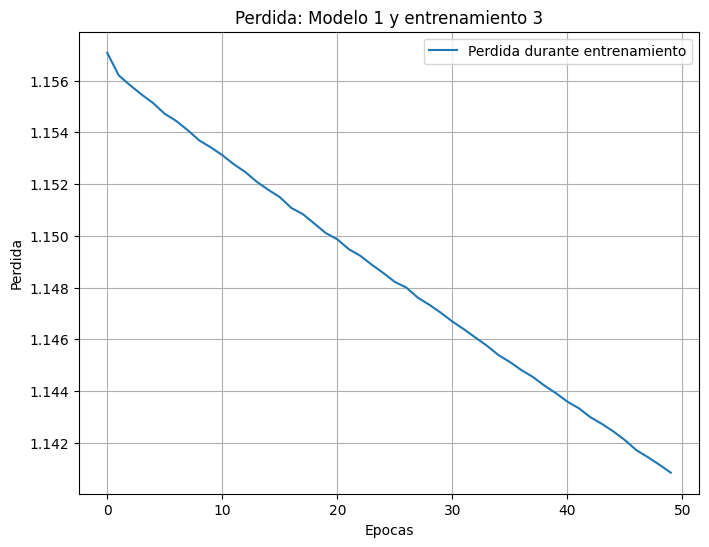

In [26]:
# Cargar el archivo history.pkl
with open('history3.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener la pérdida del conjunto de entrenamiento
loss = history['loss']

# Graficar la pérdida del conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Perdida durante entrenamiento')
plt.title('Perdida: Modelo 1 y entrenamiento 3')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

Es posible notar que baja completamente más lento que nunca, que es un resultado natural al considerar el learning rate.

Se carga el modelo para predicciones.

In [27]:
model = load_model('model_3.h5')

In [28]:
random.seed(123)
idx = random.randint(0, len(X_test))
pattern = X_test[idx].flatten().tolist()
real_sequence = Y_test[idx:idx+100].flatten().tolist()

print("Initial Pattern : {}".format("".join([tokenizer.index_word[idx] for idx in pattern])))
print("Real Sequence : {}".format("".join([tokenizer.index_word[idx] for idx in real_sequence])))


temperatures = [0.2, 0.5, 1.0, 1.5]  # Lista de diferentes valores de temperatura

for temp in temperatures:
    print(f"\n--- Generated Text (Temperature: {temp}) ---")
    generated_text = []
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length, 1)
        preds = model.predict(X_batch, verbose=0)

        # Aplicar temperatura a las predicciones antes de muestrear el índice
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Muestreo de acuerdo a las probabilidades ajustadas por temperatura
        predicted_index = np.random.choice(len(preds[0]), p=preds[0])

        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]

    print("".join([tokenizer.index_word[idx] for idx in generated_text]))

Initial Pattern : f how to curse directed by <unk> <unk> . how to curse was performed at bush theatre in the london bo
Real Sequence : rough of <unk> and fulham . in a review of the production for the daily telegraph , theatre critic c

--- Generated Text (Temperature: 0.2) ---


<ipython-input-28-56e445f52def>:21: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temp


ok . the song was still a second community of the original story of the song was selected to the sec

--- Generated Text (Temperature: 0.5) ---
ond partially listeners . he also still history in the opening some periods . the blue was the idea 

--- Generated Text (Temperature: 1.0) ---
<unk> , as an angle @-@ giller chiats that its two @-@ american lrania 's percain . 
unk> — for goer

--- Generated Text (Temperature: 1.5) ---
ents of mhikals 0 ] vipatls ) winnerary garrlcland freywer , except deliber iineuphilmtionb to coty 


Son los resultados más gramaticalmente correctos y concisos, sin embargo, tambien los más alejados del texto real. Ahora las primeras 3 temperaturas contienen texto entendible y es un resultado bastante satisfactorio. Dejando de lado el hecho de que el texto es alejado al real, mantiene un buen sentido contextual.

## Segundo Modelo: Primer entrenamiento

Ahora que se han obtenido resultados para diferentes entrenamientos del modelo, se procederá a diseñar otro modelo cambian un hiperparametro que es: el tamaño de la secuencia. Se considero así, bajo la premisa de que quiza, si el modelo aprende apartir de secuencias un tanto más largas sería capaz de aprender y definir mejor los patrones y por lo tanto desempeñarse mucho mejor. Esto cambia tanto el tamaño del tensor de entrenamiento y prueba, como la entrada de la RNN.

Dado lo anterior, es necesario volver a definir los subconjuntos de entrenamiento y prueba.

Primero el de entrenamiento:

In [29]:
seq_length = 120 #Cambiamos el tamaños

X_train, Y_train = [], []

for text in X_train_text[:6000]:
    for i in range(0, len(text)-seq_length):
        inp_seq = text[i:i+seq_length].lower()
        out_seq = text[i+seq_length].lower()
        X_train.append(inp_seq)
        Y_train.append(tokenizer.word_index[out_seq])

X_train = tokenizer.texts_to_sequences(X_train) ## Retrieve index for characters from vocabulary

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

((1329756, 120, 1), (1329756,))

Luego el de prueba

In [30]:
seq_length = 120 # Tamaño de la secuencia
X_test, Y_test = [], []

for text in X_test_text[:200]: #Numero de ejemplos a usar
    for i in range(0, len(text)-seq_length):
        inp_seq = text[i:i+seq_length].lower()
        out_seq = text[i+seq_length].lower()
        X_test.append(inp_seq)
        Y_test.append(tokenizer.word_index[out_seq]) ## Retrieve index for characters from vocabulary

X_test = tokenizer.texts_to_sequences(X_test) ## Retrieve index for characters from vocabulary

X_test, Y_test = np.array(X_test, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_test)

X_test.shape, Y_test.shape

((40839, 120, 1), (40839,))

Posteriormente, se rediseña la RNN, manteniendo la misma secuencia de capas y demás hiperparametros.

In [ ]:
lstm_out = 256

model = Sequential([
                    LSTM(lstm_out, input_shape=(seq_length, 1), return_sequences=True),
                    LSTM(lstm_out),
                    Dense(len(tokenizer.word_index)+1, activation="softmax")
                ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 244)               62708     
                                                                 
Total params: 852212 (3.25 MB)
Trainable params: 852212 (3.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se compila.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy")

Entrenamos el modelo por 50 epocas y mantenemos el batch size.

In [ ]:
if False:
  history12 = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=1)

Epoch 1/50
1299/1299 [==============================] - 271s 203ms/step - loss: 2.4860
Epoch 2/50
1299/1299 [==============================] - 277s 213ms/step - loss: 2.1102
Epoch 3/50
1299/1299 [==============================] - 276s 213ms/step - loss: 1.9744
Epoch 4/50
1299/1299 [==============================] - 276s 213ms/step - loss: 1.8785
Epoch 5/50
1299/1299 [==============================] - 276s 212ms/step - loss: 1.8061
Epoch 6/50
1299/1299 [==============================] - 275s 212ms/step - loss: 1.7489
Epoch 7/50
1299/1299 [==============================] - 275s 212ms/step - loss: 1.7018
Epoch 8/50
1299/1299 [==============================] - 275s 211ms/step - loss: 1.6622
Epoch 9/50
1299/1299 [==============================] - 274s 211ms/step - loss: 1.6281
Epoch 10/50
1299/1299 [==============================] - 274s 211ms/step - loss: 1.5997
Epoch 11/50
1299/1299 [==============================] - 274s 211ms/step - loss: 1.5740
Epoch 12/50
1299/1299 [==================

Continuamos guardando el modelo y su historial.

In [ ]:
if False:
  model.save('model_12.h5')

  with open('history12.pkl', 'wb') as file:
      pickle.dump(history12.history, file)



Mostramos el primer historial de perdida.

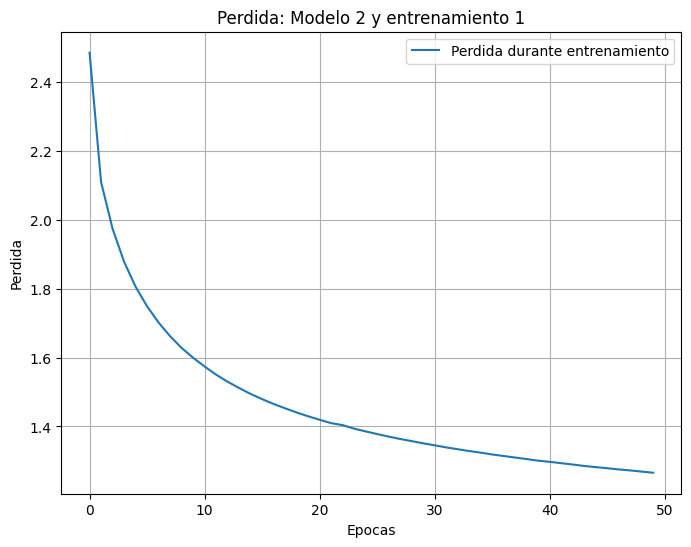

In [33]:
# Cargar el archivo history.pkl
with open('history12.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener la pérdida del conjunto de entrenamiento
loss = history['loss']

# Graficar la pérdida del conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Perdida durante entrenamiento')
plt.title('Perdida: Modelo 2 y entrenamiento 1')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

En general luce bastante similar al del anterior modelo, baja exponencialmente y trata de converger hacia un punto, no hay mucho que decir ya que no se tienen valores exactos.

Se carga el modelo y se realizan predicciones.

In [35]:
model = load_model('model_12.h5')

In [36]:
random.seed(123)
idx = random.randint(0, len(X_test))
pattern = X_test[idx].flatten().tolist()
real_sequence = Y_test[idx:idx+100].flatten().tolist()

print("Initial Pattern : {}".format("".join([tokenizer.index_word[idx] for idx in pattern])))
print("Real Sequence : {}".format("".join([tokenizer.index_word[idx] for idx in real_sequence])))


temperatures = [0.2, 0.5, 1.0, 1.5]  # Lista de diferentes valores de temperatura

for temp in temperatures:
    print(f"\n--- Generated Text (Temperature: {temp}) ---")
    generated_text = []
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length, 1)
        preds = model.predict(X_batch, verbose=0)

        # Aplicar temperatura a las predicciones antes de muestrear el índice
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Muestreo de acuerdo a las probabilidades ajustadas por temperatura
        predicted_index = np.random.choice(len(preds[0]), p=preds[0])

        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]

    print("".join([tokenizer.index_word[idx] for idx in generated_text]))


Initial Pattern : tre in the london borough of <unk> and fulham . in a review of the production for the daily telegraph , theatre critic c
Real Sequence : harles spencer noted , " robert <unk> brings a touching vulnerability to the stage as william . " 
 

--- Generated Text (Temperature: 0.2) ---


<ipython-input-36-56e445f52def>:21: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temp


onsiders , and the shop and the same person , which was a controlled post of the season . 
 @.@ 10 i

--- Generated Text (Temperature: 0.5) ---
n the world war , and the song was not a single and a great night to the political propraphic long ,

--- Generated Text (Temperature: 1.0) ---
 and allowed all over upriva . but , outober 29 august , jr <unk> critics was ever " the state and m

--- Generated Text (Temperature: 1.5) ---
adone citvel . 
7 erlopk high pemome annudars any placed hkdnevalz . 
.. spirnshov is proowetez in a


Notamos que a diferencia del primer modelo, este para las primeras 3 temperaturas obtiene secuencias bastante logicas y con buena gramatica. A primera instancia se definiría que tal vez el cambio resulto en mejorar al modelo.

Se continuará entrenando por otras 50 epocas con un learning rate de 0.0003, de igual forma que el anterior modelo.

In [ ]:
if False:
  K.set_value(model.optimizer.learning_rate, 0.0003)
  history122 = model.fit(X_train, Y_train, batch_size=1024, epochs=50, verbose=1)

Epoch 1/50
1299/1299 [==============================] - 270s 202ms/step - loss: 1.2295
Epoch 2/50
1299/1299 [==============================] - 274s 211ms/step - loss: 1.2269
Epoch 3/50
1299/1299 [==============================] - 275s 212ms/step - loss: 1.2252
Epoch 4/50
1299/1299 [==============================] - 277s 213ms/step - loss: 1.2236
Epoch 5/50
1299/1299 [==============================] - 276s 213ms/step - loss: 1.2223
Epoch 6/50
1299/1299 [==============================] - 276s 212ms/step - loss: 1.2211
Epoch 7/50
1299/1299 [==============================] - 275s 212ms/step - loss: 1.2196
Epoch 8/50
1299/1299 [==============================] - 276s 212ms/step - loss: 1.2185
Epoch 9/50
1299/1299 [==============================] - 278s 214ms/step - loss: 1.2172
Epoch 10/50
1299/1299 [==============================] - 276s 212ms/step - loss: 1.2158
Epoch 11/50
1299/1299 [==============================] - 276s 212ms/step - loss: 1.2146
Epoch 12/50
1299/1299 [==================

Se guarda el modelo y el historial

In [ ]:
if False:
  model.save('model_122.h5')

  with open('history122.pkl', 'wb') as file:
      pickle.dump(history122.history, file)

Mostramos el historial

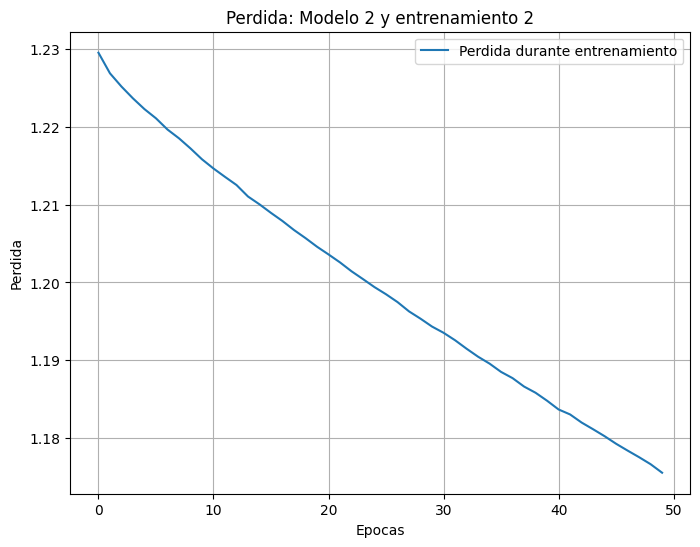

In [34]:
# Cargar el archivo history.pkl
with open('history122.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener la pérdida del conjunto de entrenamiento
loss = history['loss']

# Graficar la pérdida del conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Perdida durante entrenamiento')
plt.title('Perdida: Modelo 2 y entrenamiento 2')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)
plt.show()

En este caso, sí se nota una diferencia al compararlo con el anterior modelo, ya que en este los niveles de perdida no son tan bajos como en el anterior. Si bien esto podría ser preocupante, no puede obtenerse una conclusión apresurada debido a que existen diferentes explicaciones como el cambio en la función de perdida al aumentar el tamaño de la secuencia.

Cargamos el modelo y predecimos.

In [37]:
model = load_model('model_122.h5')

In [38]:
random.seed(123)
idx = random.randint(0, len(X_test))
pattern = X_test[idx].flatten().tolist()
real_sequence = Y_test[idx:idx+100].flatten().tolist()

print("Initial Pattern : {}".format("".join([tokenizer.index_word[idx] for idx in pattern])))
print("Real Sequence : {}".format("".join([tokenizer.index_word[idx] for idx in real_sequence])))


temperatures = [0.2, 0.5, 1.0, 1.5]  # Lista de diferentes valores de temperatura

for temp in temperatures:
    print(f"\n--- Generated Text (Temperature: {temp}) ---")
    generated_text = []
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length, 1)
        preds = model.predict(X_batch, verbose=0)

        # Aplicar temperatura a las predicciones antes de muestrear el índice
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Muestreo de acuerdo a las probabilidades ajustadas por temperatura
        predicted_index = np.random.choice(len(preds[0]), p=preds[0])

        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]

    print("".join([tokenizer.index_word[idx] for idx in generated_text]))

Initial Pattern : tre in the london borough of <unk> and fulham . in a review of the production for the daily telegraph , theatre critic c
Real Sequence : harles spencer noted , " robert <unk> brings a touching vulnerability to the stage as william . " 
 

--- Generated Text (Temperature: 0.2) ---


<ipython-input-38-56e445f52def>:21: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temp


ontrolled a special district of the country and the second team . the concept of the second time , t

--- Generated Text (Temperature: 0.5) ---
he album to the part of the converting in the team to patch , and a falling of the second community 

--- Generated Text (Temperature: 1.0) ---
's literal time – there idan available from the team was a <unk> chamber ; the <unk> vacdey @-@ tran

--- Generated Text (Temperature: 1.5) ---
 biry knonguigs and 16nk> " sujworked pich bingorkh variation counss itsigasing down thomaklish prac


Parecería que en este caso, el modelo ahora alucina un poco más y se vuelven menos concisas las respuestas, siendo solo las primeras un poco más realistas. Esto podría en primera parte deberse a que posiblemente el modelo se este sobreajustando aún con el tamaño disminuido del learning rate.

Debido a estos resultados, el modelo no se continuará entrenando.



---



## Resultados

Dentro de los modelos que se entrenaron, no se podría definir que existe uno mejor que el otro, consideraría que ambos tienen sus ventajas en comparación del otro. El primero, se desempeña mucho mejor conforme se va entrenando más lo cual resulta una ventaja ya que es posible mejorarlo a través del tiempo. Por otro lado, el primero se desempeño bien con pocas epocas y esto resulta bastante bueno si no se cuenta con suficiente tiempo. El mayor de los problemas acerca del segundo modelo recae en el tiempo de entrenamiento, el cual fue de alrededor de 5 a 6 horas, lo cual puede volverse un problema de recuros y tiempo.

## Conclusión

A lo largo de este trabajo se pudo comprender adecuadamente el diseño, entrenamiento, prueba y uso de RNN para la generación de texto, utilizando capas LSTM con un enfoque de caracteres. Se logro obtener resultados satisfactorios con longitudes de secuencias de 100 y 120 caracteres a través de 4 temperaturas, siendo las dos primeras (0.2 y 0.5) las mejores para generar texto más conciso, gramaticamente correcto e incluso comprensible.

No se logró analizar adecuadamente el desempeño debido a la falta de los resultados de precisión y validación durante el entrenamiento, lo cual hubiera servido para enfocar mejor los resultados a crear un mejor y más completo modelo.

Para futuros trabajos, se recomendaría buscar entrenar los modelos durante más tiempo con menores learning rate, así como aumentar la cantidad de ejemplos a tomar para los subsets con el fin de proveer un entrenamiento más eficaz y lograr que el modelo generalice adecuadamente.